## Question 1

Now, bidders draw cost $c_i$ from cdf $F(\cdot)$ and get payoff $(b_i-c_i)$. In order to derive the symmetryic Nash equilibrium bidding strategy we use the revelation principle to restrict attention to direct mechanisms where participants only report $c_i$ to a bidding function $b(c)$. Now we must compute $b(c)$, the bid corresponding to $c_i$. We know that firms make expected ax ante profits

$$\pi(c, b,F(\cdot)) = (b(c) - c_i)(1-F(c))^{i-1}$$

The necessary first order condition with respect to the agent's report $c$ when $c = c_i$

$$\dfrac{\partial }{\partial c}b(c)(1-F(c))^{i-1} = \dfrac{\partial}{\partial c}c_i(1-F(c))^{i-1}  $$

Integrating from $c_i$ to $\bar{c}$  (making use of the corner condition $\bar{c} = b(\bar{c})$) we have that

$$ b(c_i)(1-F(c_i))^{i-1} - \bar{c}(1-F(\bar{c}))^{i-1} = \bar{c}(1-F(\bar{c}))^{i-1} - \int^{\bar{c}}_{c_i} c d(1-F(c))^{i-1} $$

We know that $F(\bar{c})=1$ so we can further simplify

$$ b(c_i)(1-F(c_i))^{i-1} = - \int^{\bar{c}}_{c_i} c d(1-F(c))^{i-1} $$

Integrating by parts we get that

$$ b(c_i)(1-F(c_i))^{i-1} =  c_i (1-F(c_i))^{i-1} + \int_{c_i}^{\bar{c}}(1-F(c))^{i-1} dc $$

Dividing through by $(1-F(c_i))^{i-1}$ we get the usual formula, however the markup is positive

$$b(c_i) = c_i + \int^{\bar{c}}_{c_i}\dfrac{(1-F(c))^{i-1}}{(1-F(c_i))^{i-1}} dc $$



## Question 2

### Part A- B

We want to estimate the individual distribution of valuations $G^i(m|b)$. To do this we non-parametrically estimate the ditribution of bids and then using the following formula from class to estimate valutions.

$$v_i = b_i + \dfrac{G^i_{mb}(b,b)}{g^i_{mb}(b,b)}$$

Using estimated valuations, we can estimate the distribution of values non-parametrically. This estimator will use the uniform kernel and the silverman bandwith $h = 1.06 \hat{\sigma} n^{-1/5}$

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import fsolve

In [2]:
fpa_data = np.genfromtxt('fpa.dat', delimiter='     ')
ascending_data = np.genfromtxt('ascending_data.dat', delimiter='    ')

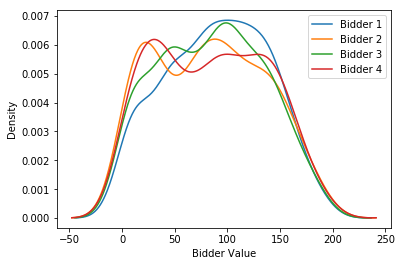

In [3]:
def apv_helper(data,i):
    """calculate the amount of shadding at each bid"""
    #calc bandwith
    data = data.copy()
    T, n = data.shape
    sigma = data.std(axis=0)[i]
    h = 1.06*sigma*T**(-1./5.) #use silverman bandwith
    
    #set up data
    support = data[:,i]
    support.sort()
    bt = np.repeat(support,T)
    bs = np.tile(data[:,i], T)
    ms = np.tile(data.max(axis=1),T)

    #caluclate formula inside the sum
    kernel1 = stats.norm.pdf( (bt - bs)/h ) #Guassian Kernel
    kernel2 = stats.norm.pdf( (bt - ms)/h )
        
    ind = ms <= bt
    
    cdf = (kernel1*ind).reshape(T,T)
    cdf = cdf.sum(axis=1)/(T*h)

    pdf = (kernel1*kernel2).reshape(T,T)
    pdf =  pdf.sum(axis=1)/(T*h**2)
    return support + cdf/pdf
    
marginals = []
apv_values = []

for i in range(4):
    v = apv_helper(fpa_data,i) 
    apv_values.append(v)
    
    kde = sm.nonparametric.KDEUnivariate(v)
    kde.fit()
    marginals.append(kde)
    
    plt.plot(kde.support, kde.density, label='Bidder %s'%(i+1) )

plt.legend()
plt.xlabel('Bidder Value')
plt.ylabel('Density')
plt.show()

We can see from the graph that the density for the private valuations are roughly the same for all of the bidders

### Part C

In [4]:
def enum_vectors(quantiles,n):
    """recursively enumerate all the quantiles"""
    if n == 1:
        vectors = []
        for q in quantiles:
            vectors.append([q])
        return vectors
    if n > 1:
        vectors = enum_vectors(quantiles,n-1)
        new_vectors = []
        for q in quantiles:
            for v in vectors:
                new_vectors.append(v + [q])
        return new_vectors
        

In [5]:
kde_mv = sm.nonparametric.KDEMultivariate(np.array(apv_values).transpose(),['c','c','c','c'])
vectors = enum_vectors([.25,.75],4)

for v in vectors:
    inverse_v = []
    for i in range(4):
        index = (marginals[i].cdf <= v[i]).sum()
        inverse_v.append( marginals[i].support[index] )
    print '==============================================================================================='
    print ' Quantile: %s | Values: %s | CDF %s'%(v, np.round(inverse_v,2) ,np.round(kde_mv.cdf(inverse_v),2))

 Quantile: [0.25, 0.25, 0.25, 0.25] | Values: [51.11 36.38 43.36 38.18] | CDF 0.11
 Quantile: [0.75, 0.25, 0.25, 0.25] | Values: [128.96  36.38  43.36  38.18] | CDF 0.13
 Quantile: [0.25, 0.75, 0.25, 0.25] | Values: [ 51.11 125.63  43.36  38.18] | CDF 0.14
 Quantile: [0.75, 0.75, 0.25, 0.25] | Values: [128.96 125.63  43.36  38.18] | CDF 0.17
 Quantile: [0.25, 0.25, 0.75, 0.25] | Values: [ 51.11  36.38 124.3   38.18] | CDF 0.14
 Quantile: [0.75, 0.25, 0.75, 0.25] | Values: [128.96  36.38 124.3   38.18] | CDF 0.17
 Quantile: [0.25, 0.75, 0.75, 0.25] | Values: [ 51.11 125.63 124.3   38.18] | CDF 0.18
 Quantile: [0.75, 0.75, 0.75, 0.25] | Values: [128.96 125.63 124.3   38.18] | CDF 0.25
 Quantile: [0.25, 0.25, 0.25, 0.75] | Values: [ 51.11  36.38  43.36 129.21] | CDF 0.14
 Quantile: [0.75, 0.25, 0.25, 0.75] | Values: [128.96  36.38  43.36 129.21] | CDF 0.17
 Quantile: [0.25, 0.75, 0.25, 0.75] | Values: [ 51.11 125.63  43.36 129.21] | CDF 0.18
 Quantile: [0.75, 0.75, 0.25, 0.75] | Values: [

### Part D

From the computer output above we can see that the joint cdf is very robust with respect to the quantiles. The order that we consider the bidders' quantitles doesn't matter or the quantiles themselves. For example, compare the (25 %, 25%, 75%, 75%) quantile with the (25 %, 75%, 25%, 75%). Obviously, the order has changed but the values are almost identical. This follows for other permuations of these numbers.  This would suggest (without performing a formal F test that the bidders valuations are roughly the same.

### Part E

Without re-estimating markups, I would perform an F-test to check if the different permuations of the quantiles return the same output for the cdf. In particular my null hypothesis would be that the bidders have assymetric values. For example, 

$$H_0: G_{.25,.25,.25,.75} = G_{.25,.25,.75,.25} = G_{.25,.75,.25,.25} = G_{.75,.25,.25,.25} $$

### Part F

We re-estimate the distributions with the independence assumption below

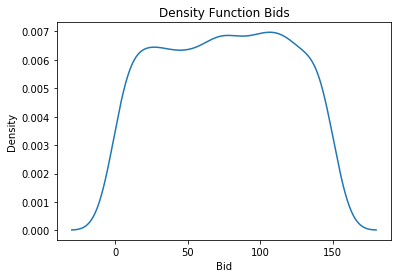

In [6]:
fpa_reshape = fpa_data.reshape(fpa_data.shape[0]*fpa_data.shape[1],)

#plot kde of bids
kde_bids = sm.nonparametric.KDEUnivariate(fpa_reshape)
kde_bids.fit()

plt.plot(kde_bids.support, kde_bids.density)
plt.title('Density Function Bids')
plt.xlabel('Bid')
plt.ylabel('Density')
plt.show()

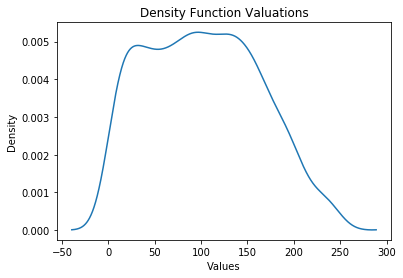

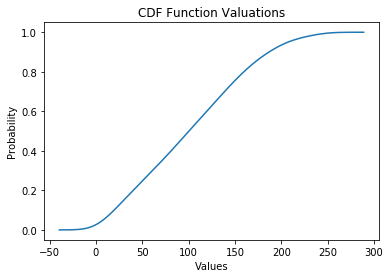

In [7]:
def est_values(data):
    """calculate values based on the formula in GPV"""

    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit()
    g = interp1d(kde.support,kde.density)
    G = interp1d(kde.support,kde.cdf)
    return data + G(data)/g(data)/(3.)



values = est_values(fpa_reshape)
kde = sm.nonparametric.KDEUnivariate(values)
kde.fit()

plt.plot(kde.support, kde.density)
plt.title('Density Function Valuations')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

plt.plot(kde.support, kde.cdf)
plt.title('CDF Function Valuations')
plt.xlabel('Values')
plt.ylabel('Probability')
plt.show()

## Question 3

In [8]:
from scipy.optimize import fsolve
ascending_data = np.genfromtxt('ascending_data.dat', delimiter='    ')

def english_helper(data):
    #calculate empirical cdf
    data = data.copy()
    ns = np.arange( data[:,0].min(),data[:,0].max()+1,1)

    cdfs = []
    supps = []
    for n in ns:
        support = data[:,1][data[:,0]==n]
        support, bids = support.copy(), support.copy()
        support.sort()
        supps.append(support)
        
        T = support.shape[0]

        bt = np.repeat(support,T)
        bs = np.tile(bids, T)

        pdf = 1.*(bt >= bs)
        pdf = pdf.reshape(T,T)
        pdf =  pdf.sum(axis=1)/(T)
        cdfs.append(pdf)
        
    return ns, supps, cdfs


def calc_phi(cdf,n):
    integral = lambda t: n*(n-1)*((1-t)*t**(n-2))
    new_cdf = np.array([])
    for F in cdf:
        phi = lambda h: F - quad(integral, 0, h)[0]
        result = fsolve(phi,F)
        new_cdf = np.concatenate((new_cdf, result))
    return new_cdf

print calc_phi(np.array([.07,.255,.26]),4)

[1.32326313 0.45998518 0.46361545]


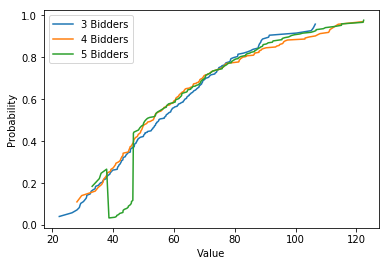

In [10]:
#plot the values implied by the order statistic

ascending_data = np.genfromtxt('ascending_data.dat', delimiter='    ')
ns, supps, cdfs = english_helper(ascending_data)
for i in range(int(ns[-1] - ns[0]+1)):
    value = calc_phi(cdfs[i], ns[i])
    plt.plot(supps[i][(value<1) & (value >0)], value[(value<1) & (value >0)]
             , label = '%s Bidders'%int(ns[i]))
    
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.show()